In [15]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import math
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Import csv file and name the columns
file = 'transaction_files/Child 1.csv'
df = pd.read_csv(file, sep=';')

# Drop columns that are not needed
df.drop(columns=['account', 'other_account', 'name', 'transaction_value'], axis=1, inplace=True)
df.rename(columns = {'balance_after_transaction':'balance'}, inplace = True)

# Change date from str to datetime, make it the index
df['date'] = pd.to_datetime(df['date'] , format= '%Y-%m-%d')
df = df.set_index('date')

# Change dates to weeks with mean balance of that week and fill empty weeks with the value of the week before (as it stayed the same)
df = df.resample('W-MON', label='left').mean()
df = df.fillna(method='ffill')

# Show dataframe head
df.head(5)

,balance
date,
2020-05-04,49.670000
2020-05-11,48.520000
2020-05-18,62.105000
2020-05-25,56.156667
2020-06-01,80.510000


Nice, let's plot the data on a timeline to see the current balance over a 2 year period.

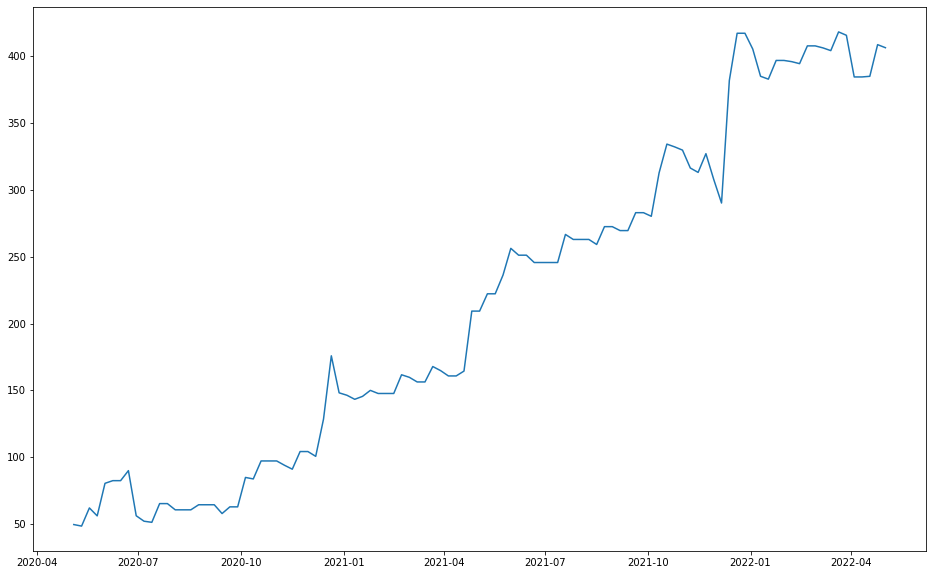

In [16]:
# Plot balance against time from dataframe as linegraph
plt.figure(figsize = (16,10))
plt.plot(df)


Even though the graph has clear increases at 5 specific moments the overall expenses vs income seem very balanced. Let's check out the lag plot.

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

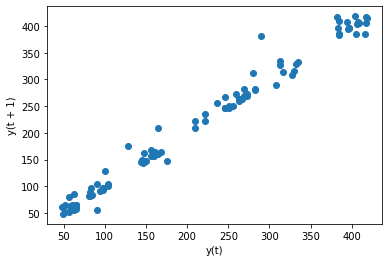

In [17]:
# print a lag plot to see if an Auto-regressive model is a good choice
from pandas.plotting import lag_plot
lag_plot(df)

The lag plot shows a linear shape and therefor suggests an autoregressive model is a good choice. There are a few outliers but within reasonable acceptance. 

To check if the data is stationary or not, we use the ad fuller method. This method takes into account the original dataset and gives a p-value to the null hypothesis that the data is nonstationary. So if you have the p-value from the ad-fuller method to be less than 0.05 (generally accepted p-value), we can reject the null hypothesis that the data is non-stationary, meaning that the data is indeed stationary.

In [18]:
# Check if data is stationary or not with the Augmented Dickey-Fuller test
adf_result = adfuller(df, autolag='BIC')

# Print the results
print(f'Results of the augmented Dickey-Fuller test')
print(f'We have a null hypothesis and an alternative hypothesis')
print(f'H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.')
print(f'HA: The time series is stationary.\n')
print(f'When the test statistic is lower than the critical values shown, The null hypothesis can be rejected, concluding that the time series is stationary. The p-value tells us about the probability of reaching these results with luck, if the value is below 0.05 (95% significance) we can reject the null hypothesis.\n')

print(f'Test statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
for key, value in adf_result[4].items():
    print(f'critial value {key}: {value}')

print(f'\nSince the test statistic {adf_result[0]} is higher than the critical values {adf_result[4]["1%"]},{adf_result[4]["5%"]},{adf_result[4]["10%"]} (t-values at 1%, 5% and 10%) the null hypothesis cannot be rejected. So, the data is non stationarity. As the p-value {adf_result[1]} is also higher than 0.05 it tells us results are not significant enough to reject the null hypothesis\n')
print(f'We can conclude the data is non stationary (that means it has relation with time)')

Results of the augmented Dickey-Fuller test
We have a null hypothesis and an alternative hypothesis
H0: The time series is non-stationary. In other words, it has some time-dependent structure and does not have constant variance over time.
HA: The time series is stationary.

When the test statistic is lower than the critical values shown, The null hypothesis can be rejected, concluding that the time series is stationary. The p-value tells us about the probability of reaching these results with luck, if the value is below 0.05 (95% significance) we can reject the null hypothesis.

Test statistic: -0.409249662045018
p-value: 0.908542922337872
critial value 1%: -3.4948504603223145
critial value 5%: -2.889758398668639
critial value 10%: -2.5818220155325444

Since the test statistic -0.409249662045018 is higher than the critical values -3.4948504603223145,-2.889758398668639,-2.5818220155325444 (t-values at 1%, 5% and 10%) the null hypothesis cannot be rejected. So, the data is non stationari

We work with the ARIMA model
AR = Auto regressive. a time series is auto regressive when present values van be obtained using previous values of the time series.
I = Integrated. 
MA = Moving average. The present value of a series is defined as a linear combination of past errors. Assumption is that they are independently distibuted with the normal distribution.

Plotting the ACF (auto correlation) and PACF (partial autocorrelation) plots can be used to obtain values of p and q, as inputs to the ARIMA model.

p: the number of lag observations in the model; also known as the lag order.
q: the size of the moving average window; also known as the order of the moving average.
d: is the number of differencing needed to make the time series stationary (needed with non stationary data)

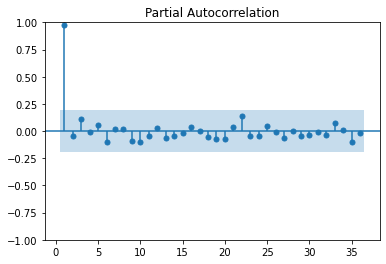

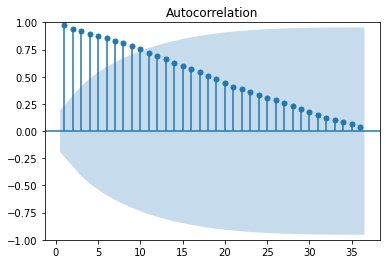

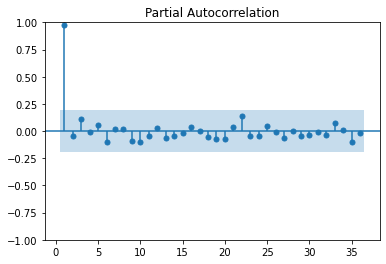

In [19]:
# ACF is autocorrelation function. An ACF plot, plots values of autocorrelation and confidence band, shows how well present value of the series is related with past values.
plot_acf(df, lags = 36, zero = False)

# PACF is partial autocorrelation function, it finds correlations of the residuals with the next lag value therefor partial as it removes already found variations before it finds the next correlation. 
plot_pacf(df, lags = 36, zero = False, method='ywm')

Using the auto arima model, this model automatically searches for p, q, and d values to fit the data. Inputs are:
Seasonal = True: This makes sure it also looks for seasonal models
m = 12: This is the length of a season, now set to 12 as in 12 weeks (the data is transferred to a mean per week, a season lasting roughly a quarter was fast with good results)
d = 1: The order of first differencing
D = 1: The order of seasonal differencing
Information_criterion=‘bic’: The Bayesian Information Criterion score is used to find the best performing model
Trace=True: The code will report all models it tried
Error_action=warn: Will warn but not stop when an error with fitting is discovered. 
N_fits=100: Limit fitting tries to 100
Stepwise=True: Go over the models step-by-step instead of searching all models, making the fitting faster. The fitting process is needed for every user (different patterns); going stepwise will speed up the experience.

In [35]:
results = pm.auto_arima(df, seasonal=True, m=12, d=1, D=1, information_criterion='bic', trace=True, error_action='warn', n_fits=100, stepwise=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=inf, Time=0.46 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=836.372, Time=0.00 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=822.477, Time=0.58 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=inf, Time=0.14 sec
 ARIMA(1,1,0)(0,1,0)[12]             : BIC=840.701, Time=0.01 sec
 ARIMA(1,1,0)(2,1,0)[12]             : BIC=820.690, Time=0.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : BIC=inf, Time=0.51 sec
 ARIMA(1,1,0)(1,1,1)[12]             : BIC=inf, Time=0.19 sec
 ARIMA(0,1,0)(2,1,0)[12]             : BIC=816.874, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : BIC=818.414, Time=0.02 sec
 ARIMA(0,1,0)(2,1,1)[12]             : BIC=inf, Time=0.58 sec
 ARIMA(0,1,0)(1,1,1)[12]             : BIC=inf, Time=0.14 sec
 ARIMA(0,1,1)(2,1,0)[12]             : BIC=820.165, Time=0.18 sec
 ARIMA(1,1,1)(2,1,0)[12]             : BIC=821.193, Time=0.51 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : BIC=821.368, Time=

The numbers after the model indicate the P,D,Q values: In this case 0,1,1 

In [36]:
# We can get a summary of the results of this model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  105
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -401.654
Date:                            Sun, 05 Jun 2022   AIC                            809.308
Time:                                    22:18:21   BIC                            816.874
Sample:                                         0   HQIC                           812.362
                                            - 105                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.6631      0.085     -7.789      0.000      -0.830      -0.496
ar.S.L24      -0.3382      0.140     -2.417      0.016      -0.612      -0.064
sigma2       338.7837     26.631     12.721      0.000     286.588     390.980
===================================================================================
Ljung-Box (L1) (Q):                   0.71   Jarque-Bera (JB):               130.44
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             1.37
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ljung-Box shows the value of the test statistic at lag 1; Prob (Q) is the probability. Because this p-value of the Ljung-Box test is greater than 0.05, the null hypothesis could not be rejected that the residuals are independent. So, they are independent = white noise. Heteroscedasticity tests if the error residuals are homoscedastic or have variance. Because the p-value of the heteroskedasticity test is lower than 0.05, the null hypothesis should be accepted that the error variances are heteroskedastic. Jarque-Bera tests for the normality of errors. It tests if the data is normally distributed; if the sigma value (σ) for the standard deviation of the curve is normally distributed. If the probability is below 0.05, the data is not normally distributed. There is no normal distribution, we can also see a slight skew and a large Kurtosis.

We split the data in a test and training set, and print the shape of the test.

In [37]:
train, test = train_test_split(df, test_size =0.2)

test.shape

(21, 1)

The test data is 21 weeks, we are going to predict these results in the test DataFrame with a new column, predicted balance.

In [38]:
n_periods = test.shape[0]
prediction = pd.DataFrame(results.predict(n_periods = n_periods), test.index)
prediction.columns = ["predicted_balance"]
test["predicted_balance"] = prediction

test

,balance,predicted_balance
date,,
2021-12-13,381.866667,410.426106
2021-12-20,417.195000,407.654560
2021-12-27,417.195000,401.922269
2022-01-03,405.390000,435.721413
2022-01-10,385.010000,446.511088
2022-01-17,382.860000,450.315143
2022-01-24,396.860000,456.618841
2022-01-31,396.860000,446.770077
2022-02-07,395.940000,445.364791


As you can see the test DataFrame is filled, but was is the RMSE value of these predictions

In [39]:


mse = mean_squared_error(test['balance'], test['predicted_balance'])
rmse = math.sqrt(mse)
print('Testing Mean Squared Error is {}'.format(mse))
print('Testing Root Mean Squared Error is {}'.format(rmse))

Testing Mean Squared Error is 4361.366368126962
Testing Root Mean Squared Error is 66.04064179069553


It shows the prediction is still sligthly off with a RMSE of 66.04, we can also plot the results to make it more visual.

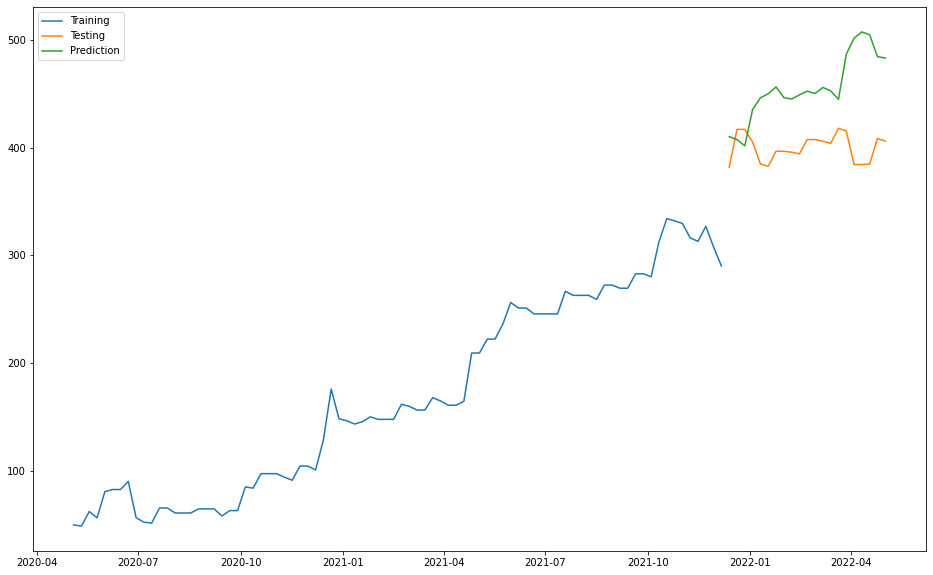

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize = (16,10))
plt.plot(train, label = "Training")
plt.plot(test.balance, label = "Testing")
plt.plot(prediction, label = "Prediction")
plt.legend()

Quite good results on this test set, lets use it to predict the future. We run a while loop to the target amount of 800, if not reached in 10 years it will drop out. It saves the results to a new dataframe.

In [41]:
goal_amount = 800
i = 1
predictionlist = [0]

while predictionlist[-1] < goal_amount:
    predictionlist = results.predict(n_periods = i)
    i += 1
    if i == 521:
        result = 'negative'
        break
    else:
        result = 'positive'
        pass

future_dates = [df.index[-1] + DateOffset(weeks = x) for x in range(0,i)]
future_date_df = pd.DataFrame(index = future_dates[1:],columns = df.columns)
future_date_df["forecast"] = results.predict(n_periods = i-1, dynamic  = True )
future_df = pd.concat([df,future_date_df])
future_df

print(future_date_df.tail())

           balance    forecast
2024-06-03     NaN  773.104705
2024-06-10     NaN  772.816211
2024-06-17     NaN  766.948863
2024-06-24     NaN  798.954333
2024-07-01     NaN  809.686810


It seems like we would get our 800 euros in the week of 1 july 2024. Let's plot this DataFrame to see the journey.

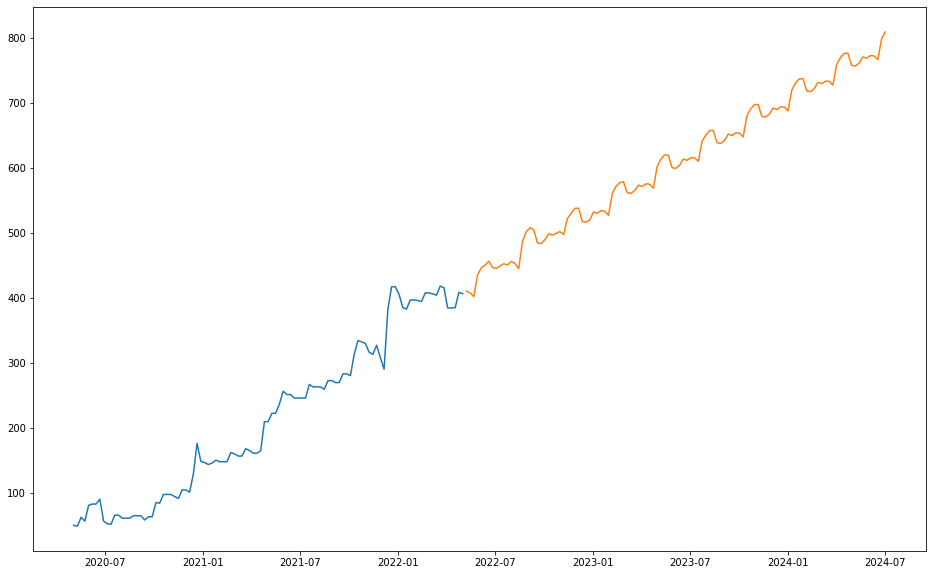

In [42]:
plt.figure(figsize = (16,10))
plt.plot(future_df)


A function to eventually get this connected with a front end. The user provides a target date and the system will communicate if it makes that date.

In [43]:
import functions as f
goal_date = f.parsed_date('2022-08-19')

new_df = future_df.reset_index()
actual_date = new_df['index'].iloc[-1]
actual_amount = round(new_df['forecast'].iloc[-1], 2)

print('have result, printing result')
if result == 'negative':
    print(f'You are not going to reach it in the coming 10 years, on {actual_date}, you will have {actual_amount} we suggest you find help')
else:
    if actual_date > goal_date:
        print(f'You reach the goal in the week of {actual_date} you will have {actual_amount} then')
        print(f'We need you to step up your game')
    elif actual_date == goal_date:
        print(f'You reach the goal in the week of {actual_date} you will have {actual_amount} then')
        print(f'You are precisely where you need to be')
    else:
        print(f'You reach the goal in the week of {actual_date} you will have {actual_amount} then')
        print(f'You are ahead of schedule')

have result, printing result
You reach the goal in the week of 2024-07-01 00:00:00 you will have 809.69 then
We need you to step up your game
